Dataset loaded successfully.
FraudDetectionAgent initialized. Interacting with local Ollama model: mistral

Agent is thinking and generating a rule using the local LLM...
Agent's suggested rule: If 'V17' < '-3.0', then it's fraud.

--- Agent's Rule Performance ---
Rule: If 'V17' < '-3.0', then it's fraud.
Accuracy: 0.9991
Precision: 0.7965
Recall: 0.6338
F1 Score: 0.7059


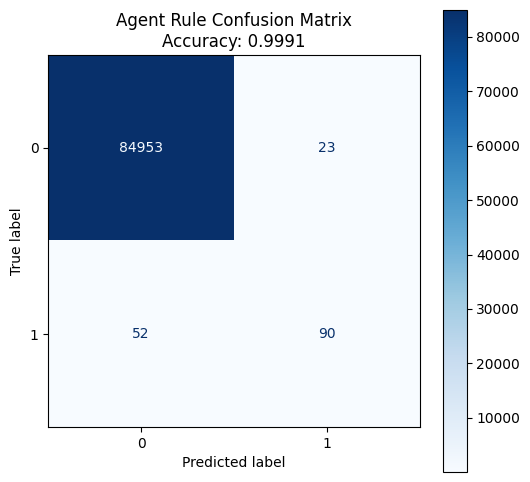


--- Comparison Notes ---
This agent-based approach uses a simple, LLM-suggested rule from a local Ollama instance.
It is designed as a 'toy example' to illustrate the concept of an agent making decisions with a local LLM.
Its performance is expected to be significantly lower than complex ML models (like LGBM, ANN, CNN, RNN, LSTM) or AutoML solutions,
which learn complex patterns from data rather than relying on a single, human-interpretable rule.
The value here is in the interpretability and the agent's 'reasoning' process, not raw performance.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import json
import requests # For interacting with Ollama API



data = pd.read_csv('/Users/albertohernandez/Documents/projects/ks-workshop/code/creditcard.csv')
df = data.copy()
print("Dataset loaded successfully.")

df.drop_duplicates(inplace=True)

# Scale 'Amount' feature as done in previous examples
amount = df['Amount'].values.reshape(-1, 1)
scaler_amount = StandardScaler()
df['Amount'] = scaler_amount.fit_transform(amount)

# Define X and y for the agent to work with
X = df.drop('Class', axis=1)
y = df['Class']

# Split data into training and testing sets (even for simple rule, useful for evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# --- Agent Implementation ---

class FraudDetectionAgent:
    def __init__(self, ollama_model_name="mistral", ollama_api_base_url="http://localhost:11434/api/generate"):
        """
        Initializes the FraudDetectionAgent to interact with a local Ollama LLM.
        Args:
            ollama_model_name (str): The name of the model downloaded in Ollama (e.g., "mistral").
            ollama_api_base_url (str): The endpoint for Ollama's generate API.
        """
        self.ollama_model_name = ollama_model_name
        self.ollama_api_base_url = ollama_api_base_url
        print(f"FraudDetectionAgent initialized. Interacting with local Ollama model: {ollama_model_name}")

    def _get_llm_suggestion(self, features):
        """
        Interacts with the local Ollama LLM to get a simple fraud detection rule.
        """
        prompt = f"""
        You are a basic fraud detection agent. Your goal is to identify fraudulent transactions in a highly imbalanced dataset where fraud is very rare (0.17% of transactions).
        You have access to the following features: {', '.join(features)}.
        Suggest a single, simple rule to detect fraud based on one of these features and a numerical threshold.
        The rule should be in the format: "If [feature_name] is [comparison_operator] [threshold_value], then it's fraud."
        For example: "If Amount is > 100.0, then it's fraud."
        Or: "If V17 is < -5.0, then it's fraud."

        Think step-by-step about which feature might be most indicative of fraud and a reasonable threshold.
        Consider that 'V' features are often PCA-transformed features, and some (e.g., V17, V14, V12) are known to be highly correlated with fraud (often having very negative values for fraudulent transactions). 'Amount' is also a direct financial feature.

        Provide your suggestion as a JSON object with 'feature_name' (string) and 'threshold_value' (float), and 'comparison_operator' (string, either '>' or '<').
        Example output: {{"feature_name": "V17", "threshold_value": -5.0, "comparison_operator": "<"}}
        """

        payload = {
            "model": self.ollama_model_name,
            "prompt": prompt,
            "format": "json", # Request JSON output from Ollama
            "stream": False, # We want a single, complete response
            "options": {
                "temperature": 0.0 # Make the LLM's response deterministic
            }
        }

        try:
            response = requests.post(self.ollama_api_base_url, headers={'Content-Type': 'application/json'}, json=payload)
            response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
            result = response.json()

            if result.get("response"):
                # Ollama's /api/generate puts the model's output in the 'response' field
                json_str = result["response"]
                return json.loads(json_str)
            else:
                print("Ollama response structure unexpected:", result)
                return None
        except requests.exceptions.ConnectionError:
            print(f"Error: Could not connect to Ollama server at {self.ollama_api_base_url}.")
            print("Please ensure Ollama is installed and the '{self.ollama_model_name}' model is running.")
            print("You might need to run 'ollama run {self.ollama_model_name}' in your terminal.")
            return None
        except requests.exceptions.RequestException as e:
            print(f"Error calling Ollama API: {e}")
            return None
        except json.JSONDecodeError:
            print("Ollama response was not valid JSON. Model might not have followed instructions.")
            print(f"Raw Ollama response: {result.get('response', 'N/A')}")
            return None

    def detect_fraud(self, X_data):
        """
        Agent's core function to detect fraud based on an LLM-suggested rule.
        """
        print("\nAgent is thinking and generating a rule using the local LLM...")
        
        # Get a rule from the local Ollama LLM
        rule_suggestion = self._get_llm_suggestion(X_data.columns.tolist())

        if not rule_suggestion:
            print("Agent failed to get a valid rule from LLM. Using a fallback rule.")
            # Fallback rule if LLM fails or returns invalid JSON
            feature = 'V17'
            threshold = -5.0
            operator = '<'
        else:
            feature = rule_suggestion.get('feature_name')
            threshold = rule_suggestion.get('threshold_value')
            operator = rule_suggestion.get('comparison_operator')
            
            # Basic validation of the LLM's suggestion
            if feature not in X_data.columns:
                print(f"LLM suggested feature '{feature}' not found in data. Using fallback.")
                feature = 'V17'
                threshold = -5.0
                operator = '<'
            if not isinstance(threshold, (int, float)):
                print(f"LLM suggested invalid threshold '{threshold}'. Using fallback.")
                threshold = -5.0
                operator = '<'
            if operator not in ['>', '<']:
                print(f"LLM suggested invalid operator '{operator}'. Using fallback.")
                operator = '<'
            
        print(f"Agent's suggested rule: If '{feature}' {operator} '{threshold}', then it's fraud.")

        # Apply the rule
        if operator == '>':
            y_pred_agent = (X_data[feature] > threshold).astype(int)
        elif operator == '<':
            y_pred_agent = (X_data[feature] < threshold).astype(int)
        else:
            # Should not happen with validation, but as a safeguard
            y_pred_agent = np.zeros(len(X_data), dtype=int)
            print("Invalid operator, defaulting to no fraud detected.")

        return y_pred_agent, feature, threshold, operator

# --- Main Execution ---

# Initialize the agent to use the Mistral model with Ollama
agent = FraudDetectionAgent(ollama_model_name="mistral")

# Have the agent detect fraud on the test set
y_pred_agent, rule_feature, rule_threshold, rule_operator = agent.detect_fraud(X_test)

# --- Evaluate Agent's Performance ---
print("\n--- Agent's Rule Performance ---")
accuracy = accuracy_score(y_test, y_pred_agent)
precision = precision_score(y_test, y_pred_agent, zero_division=0)
recall = recall_score(y_test, y_pred_agent, zero_division=0)
f1 = f1_score(y_test, y_pred_agent, zero_division=0)

print(f"Rule: If '{rule_feature}' {rule_operator} '{rule_threshold}', then it's fraud.")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred_agent)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title(f"Agent Rule Confusion Matrix\nAccuracy: {accuracy:.4f}")
plt.show()

print("\n--- Comparison Notes ---")
print("This agent-based approach uses a simple, LLM-suggested rule from a local Ollama instance.")
print("It is designed as a 'toy example' to illustrate the concept of an agent making decisions with a local LLM.")
print("Its performance is expected to be significantly lower than complex ML models (like LGBM, ANN, CNN, RNN, LSTM) or AutoML solutions,")
print("which learn complex patterns from data rather than relying on a single, human-interpretable rule.")
print("The value here is in the interpretability and the agent's 'reasoning' process, not raw performance.")
